In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 20
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS = D + K
BATCH_SIZE = 10
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset2/sequences.npy')).float()
Zs = torch.from_numpy(np.load('gmm_dataset2/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
# covs = torch.from_numpy(np.load('gmm_dataset2/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset2/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
def StatsGMM(Xs, Zs, K, D):
    """
    Xs is B * N * D
    Zs is B * N * K
    stat1 corresponds I[z_n=1], ..., I[z_n=K]
    stat2 corresponds I[z_n=1]x_n, ..., I[z_n=K]x_n
    stat3 corresponds I[z_n=1]x_n**2, ..., I[z_n=K]x_n**2
    return B * (K+D*K+D*K)
    """
    stat1 = Zs.sum(1)
    stat2 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    stat3 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(Xs, Xs).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    return stat1, stat2, torch.cat((stat1, stat2.view(-1, D*K), stat3.view(-1, D*K)), dim=-1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.mus_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.mus_log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        mean = self.mus_mean(hidden).view(-1, K, D)
        std = torch.exp(self.mus_log_std(hidden).view(-1, K, D))
        alpha = torch.exp(self.sigmas_log_alpha(hidden).view(-1, K, D))
        beta = torch.exp(self.sigmas_log_beta(hidden).view(-1, K, D))
        
        mus = Normal(mean, std).sample((num_samples, )) ## S * B * K * D
        sigmas = Gamma(alpha, beta).sample((num_samples, )) ## S * B * K * D
        
        return mean, std, alpha, beta, mus, sigmas

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
def log_joints_gmm(Z, Pi, mus, sigmas, Xs, N, D, K, num_samples, batch_size):
    log_probs = torch.zeros((num_samples, batch_size)).float()
    ## priors on mus and sigmas, S * B
    log_probs = log_probs + Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))).log_prob(mus).sum(-1).sum(-1)
    log_probs = log_probs + Gamma(torch.ones((batch_size, K, D)), torch.ones((batch_size, K, D))).log_prob(sigmas).sum(-1).sum(-1)
    ## Z B-by-T-by-K
#     log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    log_probs = log_probs + Normal(mus[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D), sigmas[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D)).log_prob(Xs).sum(-1).sum(-1)
    return log_probs
    
def rws(Xs, Zs, Pi, N, K, D, num_samples, batch_size):
    stat1, stat2, stats = StatsGMM(Xs, Zs, K, D)
    data = torch.cat((Xs, Zs), dim=-1).view(batch_size*N, -1)
    mus_mean, mus_std, sigmas_alpha, sigmas_beta, mus, sigmas = enc(data, K, D, num_samples, batch_size)
    log_q = Normal(mus_mean, mus_std).log_prob(mus).sum(-1).sum(-1) + Gamma(sigmas_alpha, sigmas_beta).log_prob(sigmas).sum(-1).sum(-1)## S * B
    log_p = log_joints_gmm(Zs, Pi, mus, sigmas, Xs, N, D, K, num_samples, batch_size)
    log_weights = log_p - log_q
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
#     posterior_mean, posterior_covs = conjugate_posterior(stat1, stat2, covs, K, D, batch_size)
#     MCKl, TrueKl = kls_gaussians(mus, mus_mean, mus_std, posterior_mean, posterior_covs, K, D)
    return eubo, elbo, ess

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [8]:
EUBOs = []
ELBOs = []
ESSs = []
# MCKls = []
# TrueKls = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    time_start = time.time()
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
#     MCKl = 0.0
#     TrueKl = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess = rws(batch_Xs, batch_Zs, Pi, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
#         MCKl += mckl.item()
#         TrueKl += truekl.item()
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
#     MCKl /= num_batches
#     TrueKl /= num_batches
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
#     MCKls.append(MCKl)
#     TrueKls.append(TrueKl)
    
    time_end = time.time()
    print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS, time_end - time_start))
#     print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f, MCKL=%f, TKL=%f (%ds)' % (epoch, EUBO, ELBO, ESS, MCKl, TrueKl, time_end - time_start))

epoch=0, EUBO=nan, ELBO=-inf, ESS=1.000 (0s)
epoch=1, EUBO=nan, ELBO=-inf, ESS=1.023 (0s)
epoch=2, EUBO=-142.435542, ELBO=-24209362208962044.000000, ESS=1.102 (0s)
epoch=3, EUBO=-132.279515, ELBO=-8518027.784455, ESS=1.127 (0s)
epoch=4, EUBO=-128.919469, ELBO=-132392.017480, ESS=1.144 (0s)
epoch=5, EUBO=-125.846002, ELBO=-1119.752112, ESS=1.159 (0s)
epoch=6, EUBO=-123.417574, ELBO=-1234.169276, ESS=1.188 (0s)
epoch=7, EUBO=-122.390397, ELBO=-415.126679, ESS=1.198 (0s)
epoch=8, EUBO=-120.815869, ELBO=-472.470156, ESS=1.208 (0s)
epoch=9, EUBO=-120.169537, ELBO=-276.957679, ESS=1.259 (0s)
epoch=10, EUBO=-118.390470, ELBO=-190.635733, ESS=1.207 (0s)
epoch=11, EUBO=-117.546656, ELBO=-189.801411, ESS=1.235 (0s)
epoch=12, EUBO=-116.961132, ELBO=-409.494542, ESS=1.269 (0s)
epoch=13, EUBO=-116.460527, ELBO=-159.257991, ESS=1.282 (0s)
epoch=14, EUBO=-116.250529, ELBO=-151.717211, ESS=1.284 (0s)
epoch=15, EUBO=-115.693851, ELBO=-150.217633, ESS=1.322 (0s)
epoch=16, EUBO=-114.740694, ELBO=-149.252

In [9]:
def plot_results(EUBOs, ELBOs, ESS, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(20, 20))
#     fig.tight_layout()
    ax1 = fig.add_subplot(2, 1, 1)
    ax3 = fig.add_subplot(2, 1, 2)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax1.tick_params(labelsize=18)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, lr=%.1E, samples=%d' % (num_epochs, lr, num_samples), fontsize=18)
    ax1.set_ylim([-150, -80])
    ax1.legend()
    ax3.legend()
    ax3.tick_params(labelsize=18)
    plt.savefig('gmm_rws_datatodist_lr=%.1E_samples=%d.svg' % (lr, orch.ones((K, D)) * 0.3 num_samples))

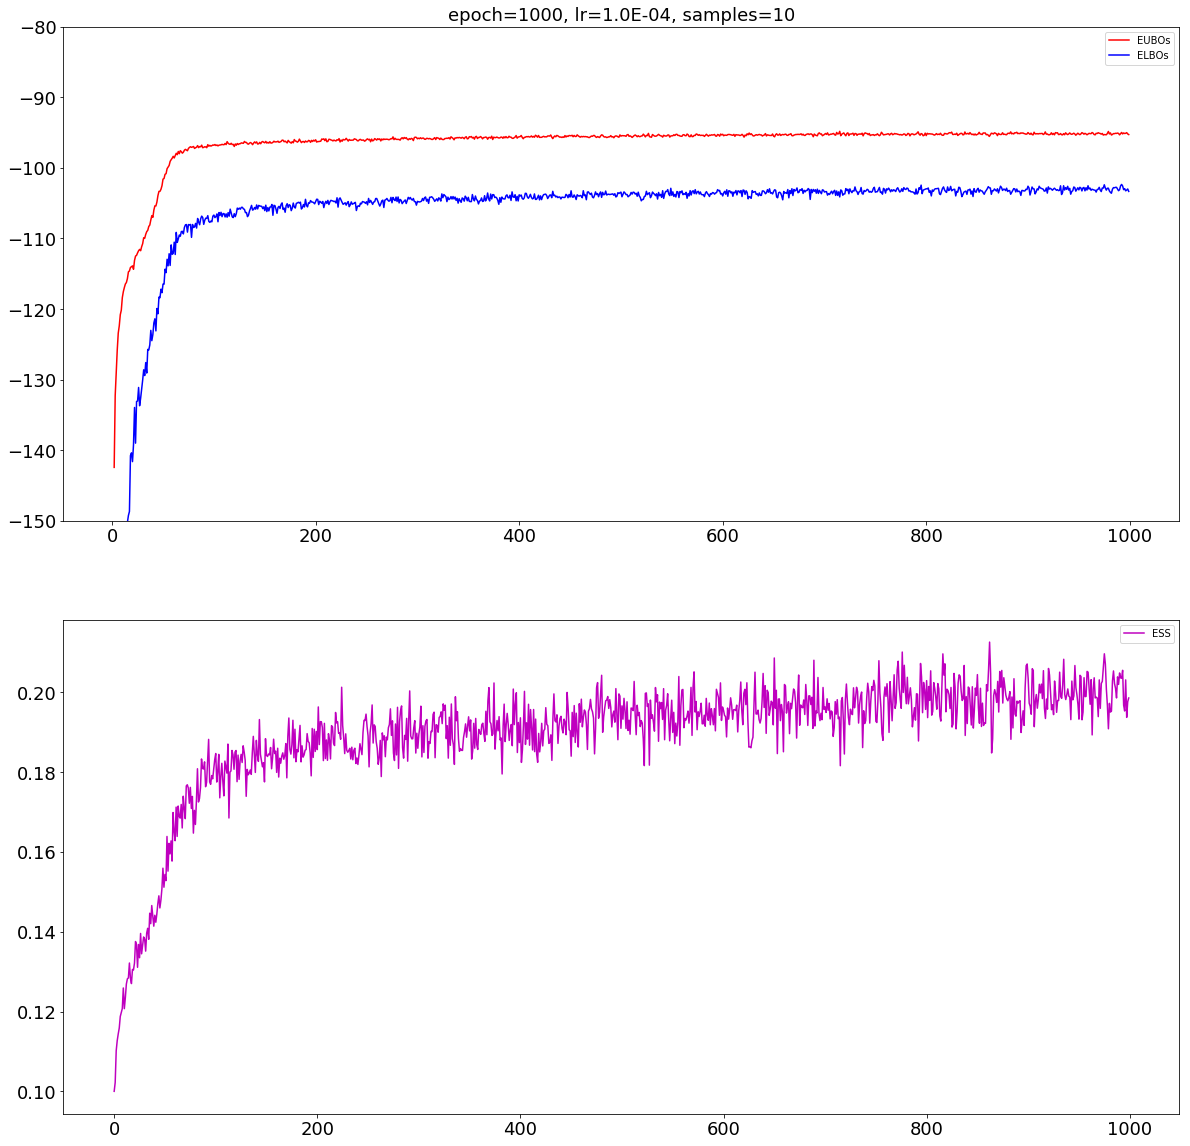

In [10]:
plot_results(EUBOs, ELBOs, ESS, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)